# Example: Properties

#### Imports

In [46]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from tad_mctc.convert import tensor_to_numpy
from tad_mctc.io import read
from tad_mctc.units import AU2DAAAMU, AU2RCM

import dxtb

In [47]:
save_as_pgf = 0
save_as_png = 0
save_as_svg = 1
save_as_pdf = 1

#### Functions

In [48]:
def fold(
    frequencies,
    intensities,
    start=800.0,
    end=4000.0,
    npts=None,
    width=4.0,
    type="Gaussian",
    normalize=True,
):
    """
    Fold frequencies and intensities within the given range
    and folding method (Gaussian/Lorentzian).
    The energy unit is cm^-1.
    normalize=True ensures the integral over the peaks to give the
    intensity.

    Taken from https://wiki.fysik.dtu.dk/ase/_modules/ase/vibrations/vibrations.html#Vibrations.fold
    """

    lctype = type.lower()
    assert lctype in ["gaussian", "lorentzian"]

    if not npts:
        npts = int((end - start) / width * 10 + 1)

    prefactor = 1
    if lctype == "lorentzian":
        intensities = intensities * width * np.pi / 2.0
        if normalize:
            prefactor = 2.0 / width / np.pi
    else:
        sigma = width / 2.0 / np.sqrt(2.0 * np.log(2.0))
        if normalize:
            prefactor = 1.0 / sigma / np.sqrt(2 * np.pi)

    # Make array with spectrum data
    spectrum = np.empty(npts)
    energies = np.linspace(start, end, npts)
    for i, energy in enumerate(energies):
        energies[i] = energy
        if lctype == "lorentzian":
            spectrum[i] = (
                intensities
                * 0.5
                * width
                / np.pi
                / ((frequencies - energy) ** 2 + 0.25 * width**2)
            ).sum()
        else:
            spectrum[i] = (
                intensities * np.exp(-((frequencies - energy) ** 2) / 2.0 / sigma**2)
            ).sum()
    return [energies, prefactor * spectrum]


def save_plot_as_pdf(fig, path):
    if save_as_pdf == 1:
        fig.savefig(path, format="pdf", bbox_inches="tight")


def save_plot_as_png(fig, path):
    if save_as_png == 1:
        fig.savefig(
            path,
            format="png",
            bbox_inches="tight",
            transparent=False,
            facecolor="white",
            edgecolor="none",
        )


def save_plot_as_svg(fig, path):
    if save_as_svg == 1:
        fig.savefig(path, format="svg", bbox_inches="tight")

#### dxtb calculation

In [49]:
FILE ="capsaicin"

In [50]:
device = torch.device("cpu")
dd: dxtb._types.DD = {"device": device, "dtype": torch.double}

f = Path(globals()["_dh"][0]) / f"{FILE}.xyz"
numbers, positions = read.read_from_path(f, **dd, ftype="xyz")
charge = read.read_chrg_from_path(f, **dd)

In [51]:
prefix = f"raman-{FILE}"

freqs = tensor_to_numpy(torch.load(f"{prefix}-freqs.pt") * AU2RCM)
ints = tensor_to_numpy(torch.load(f"{prefix}-ints.pt") * AU2DAAAMU)

numfreqs = tensor_to_numpy(torch.load(f"{prefix}-num-freqs.pt") * AU2RCM)
numints = tensor_to_numpy(torch.load(f"{prefix}-num-ints.pt") * AU2DAAAMU)

#### DFT

In [52]:
_freqs, _ints = [], []
with open("dft.txt", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i < 2:
            continue
        l = line.strip().split()
        freq, int_val = l[1], l[2]
        _freqs.append(float(freq))
        _ints.append(float(int_val))
    
# Convert lists to numpy arrays
freqs_dft = np.array(_freqs)
ints_dft = np.array(_ints)

In [53]:
print(freqs.shape, ints.shape, freqs_dft.shape)
print(numfreqs.shape, numints.shape, ints_dft.shape)

(141,) (141,) (138,)
(141,) (141,) (138,)


#### Print spectrum

In [54]:
if save_as_pdf == 1:
    normal = 26
    mpl.rc('font', size=normal+2)
    mpl.rc('axes', titlesize=normal)     # fontsize of the axes title
    mpl.rc('axes', titlepad=5)
    mpl.rc('axes', labelpad=9)
    mpl.rc('axes', labelsize=normal+2)     # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=normal)    # fontsize of the tick labels
    mpl.rc('ytick', labelsize=normal)    # fontsize of the tick labels
    mpl.rc('legend', fontsize=normal)
    mpl.rc('figure', titlesize=normal+3)   # fontsize of the figure title
    mpl.rc('lines', markersize=12)
    mpl.rc('lines', marker="")
    mpl.rc('grid', alpha=0.4)
    mpl.rc('grid', color="gray")
    mpl.rc('grid', linewidth=0.5)
    mpl.rcParams["xtick.major.size"] = 8
    mpl.rcParams["ytick.major.size"] = 8
    
    lw = 2
    ms_4 = 10
    ms_8 = 11
  
  # width of tex document in inches
    fig_width = 20
    fig_height = fig_width * 0.5

In [55]:
start = 400
end = 4000
width = 20.0
normalize = True
blue = "#004e9f"
yellow = "#fcba00"

def print_spectrum(freqs1, ints1, freqs2, ints2, freqs3, ints3):
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_height))

    ints1 = ints1 / ints1.max()
    ints2 = ints2 / ints2.max()
    ints3 = ints3 / ints3.max()

    freqs1, ints1 = fold(
        freqs1,
        ints1,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.fill_between(
        freqs1,
        ints1,
        label="GFN1-xTB (dxtb AD)",
        color=blue,
        alpha=0.5,
    )

    freqs2, ints2 = fold(
        freqs2,
        ints2,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.plot(
        freqs2,
        ints2,
        color=blue,
        alpha=1,
        lw=3,
        label="GFN1-xTB (dxtb numerical)",
    )

    freqs3, ints3 = fold(
        freqs3,
        ints3,
        start=start,
        end=end,
        width=width,
        normalize=normalize,
    )
    ax.plot(freqs3, ints3, color=yellow, alpha=1, lw=1)
    ax.fill_between(
        freqs3,
        ints3,
        color=yellow,
        label=r"$\omega$B97X-D4/def2-QZVP",
        alpha=0.5,
    )

    ax.set_xlim(start, end)
    ax.set_ylim(0)

    ax.set_title("Raman Spectrum of Capsaicin", pad=8)

    plt.xlabel("Frequency in cm$^{-1}$")
    plt.ylabel("Relative Intensity", labelpad=18)
    plt.legend(loc="upper left")
    plt.tight_layout()
    save_plot_as_pdf(fig, path="raman.pdf")
    save_plot_as_svg(fig, path="raman.svg")
    plt.show()

In [56]:
print(freqs.min(), freqs.max())

-109.1575319946085 3643.2052967387544


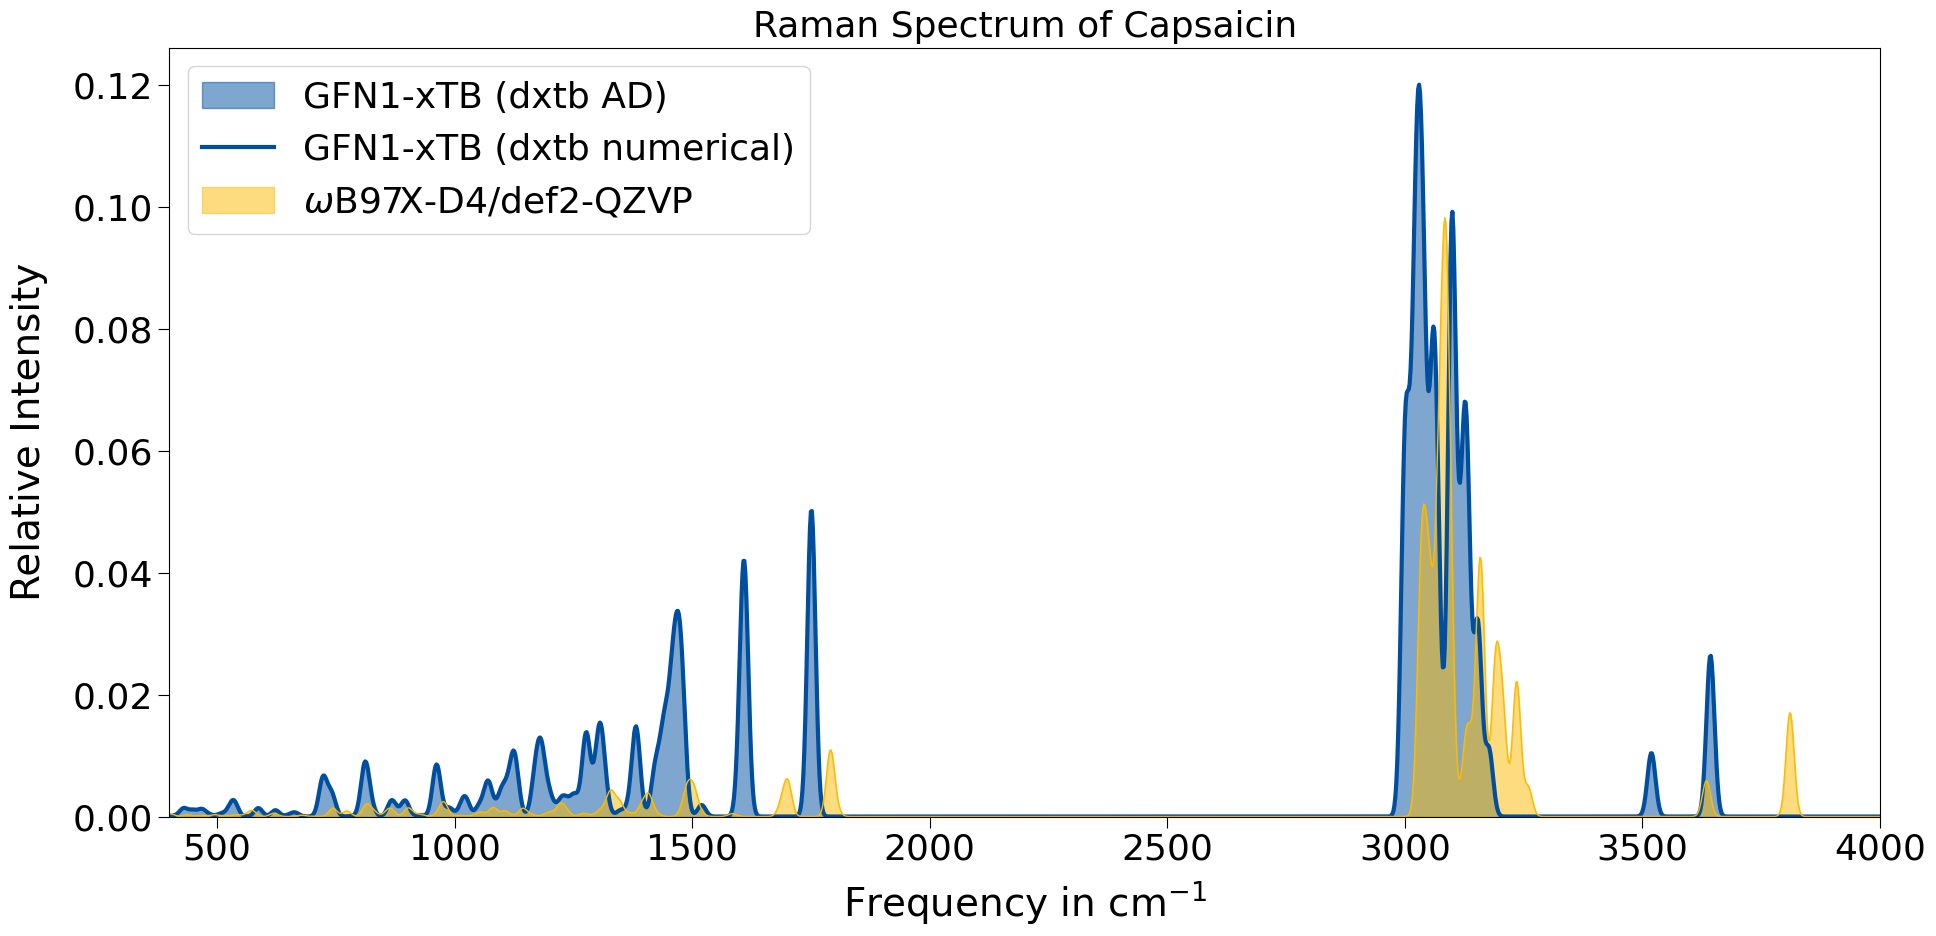

In [57]:
print_spectrum(freqs, ints, numfreqs, numints, freqs_dft, ints_dft)